# パネルデータ分析

ここまで扱ってきたデータは、１時点のデータ（クロスセクションデータ）でしたが、本節では、複数時点で繰り返し観測したデータであるパネルデータを扱います。パネルデータではクロスセクションデータでは制御できなかった要因の制御が可能になります。

関連するデータの種類を整理すると、

* 時系列データ（タイムシリーズデータ、time series data）：一定の時間間隔で収集したデータ（例　日本のマクロで見た１世帯あたりの所得の過去10年のデータ）
* 横断面データ（クロスセクションデータ、cross section data）：ある1時点での複数の主体$i$（個人、企業、地点など）のデータ
* パネルデータ（panel data）：時系列データと横断面データの両方の要素を持ち合わせたデータ。複数の主体の複数時点での観察データ

```{note}
パネルデータの推定にはいくつかの種類がありますが、本節ではPooled OLS（POLS）と固定効果（Fixed effect model, FE）の2つを取り上げます。ランダム効果（Random effect）モデルも一般的ですがここでは扱いません（重要ではないという意味ではないです。ただし、ランダム効果は観測できない個体の誤差は全ての説明変数に対して独立であるという強い過程をおいているため、実際の分析での適用は限られる場合が多いためです。）。
```

## Pooled OLS

Pooled OLS (pooled ordinary least squares, POLS)はパネルデータの構造を無視して回帰します。

$$Y_{it} = \delta D_{it} + \eta_{it};
  \quad 
  t = 1, 2, \dots,T$$

ある観察単位$i$の$t$期のパネルデータで、$Y_{it}$は被説明変数、$\delta$は推定する係数、$D_{it}$は説明変数とします。
また、$\eta=u_i+\epsilon_{it}$で、$u_i$は観測できない時間を通じて変わらない個別効果（例：観測されない個人の生まれ持った能力）、$\epsilon_{it}$は時間によって変化する観察されない効果とします。

ここで$\eta$が良い推定量を得るためには、次に示すように、$u_i$は$D_{it}$と全ての期間を通じて相関がないことが条件となります。

$$ E\big[\eta_{it}\mid D_{i1},D_{i2}, \dots, D_{iT}\big] = E\big[\eta_{it}\mid D_{it}\big] = 0
   \quad
   \text{for $t=1,2,\dots, T$}$$

また、観察単位$u_{i}$は全ての期間$t$に存在するため、$\eta_{it}$に$i$に対して系列相関（serial correlation）があります。
この条件が満たされない場合には推定値は正しくないものになってしまいます。

## 固定効果モデル（Fixed effect model, FE）

固定効果では、時間平均からの差である$\ddot{Y}_{it}$を$\ddot{D}_{it}$に回帰するか、$Y_{it}$を$D_{it}$と観察単位のダミー変数に回帰することで推定を行うことができます。
具体的には、まず各観察単位（例：各個人、各組織などiによる）について、被説明変数、説明変数の全ての時間平均を作ります。
ここで、$\overline{Y}_{i}=(Y_{i1}+\dots+Y_{iT})/T$は観察単位$i$の時間平均です。

続いてそれをそれぞれの重回帰モデルから引くと、$\ddot{Y}_{it}=\ddot{D}_{it}+\ddot{\epsilon_{it}}$
となり個別効果$u_i$を消去することができます。


時間平均で引いた変数で回帰することで、$C(D_{it},u_i)\neq 0$の場合でも$\delta$は一致性を持ちます。

$D_{it}$と$i$固有のダミー変数に回帰することと数値的には等価であるため、within推定量（within estimates）と呼ばれることもあります。また、期間$t$の固定効果を含める場合はtwo-way fixed effects推定量とも呼ばれます。

上では時間平均を用いて個別効果を制御しましたが、１階差分法(First difference estimator)もあります。

```{caution}
固定効果推定の注意点としては、逆の因果性の問題は解決できないということと、時間を通じて変化する観測できない異質性に対処できないということです。逆の因果関係としては、$D$が$Y$に影響を与えているのではなく、$Y$が$D$に影響をあたえているケースです。
```

In [34]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import matplotlib.pyplot as plt

ここでは、Rの`plm`パッケージに含まれる`Grunfeld`というデータを用います。

In [35]:
df = sm.datasets.get_rdataset("Grunfeld", "plm").data

In [38]:
df.head(5)

,firm,year,inv,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4


このデータは次の変数を格納しています。

* `inv`: 会社$i$の$t$年における投資（gross Investment）
* `value`: 発行済み株式数（value of the firm）
* `capital`: 資本金（stock of plant and equipment）

`inv`を被説明変数、`value`と`capital`としていかパネルデータ分析を適用してみます。

会社idと年次でソートします。

In [39]:
df.sort_values(['firm','year'], inplace = True)

データがbalancedかどうか（全ての観察単位が全ての期間で観測されているかどうか）確認します。

In [42]:
df.groupby(['firm']).size()

firm
1     20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
dtype: int64

In [43]:
df.groupby(['year']).size()

year
1935    10
1936    10
1937    10
1938    10
1939    10
1940    10
1941    10
1942    10
1943    10
1944    10
1945    10
1946    10
1947    10
1948    10
1949    10
1950    10
1951    10
1952    10
1953    10
1954    10
dtype: int64

会社ごとの`inv`の平均値を確認します。

In [40]:
df.groupby('firm')[['inv']].mean()

,inv
firm,
1,608.0200
2,410.4750
3,102.2900
4,86.1235
5,61.8025
6,55.4110
7,47.5955
8,42.8915
9,41.8890


会社ごとの`inv`の時系列変化をプロットします。

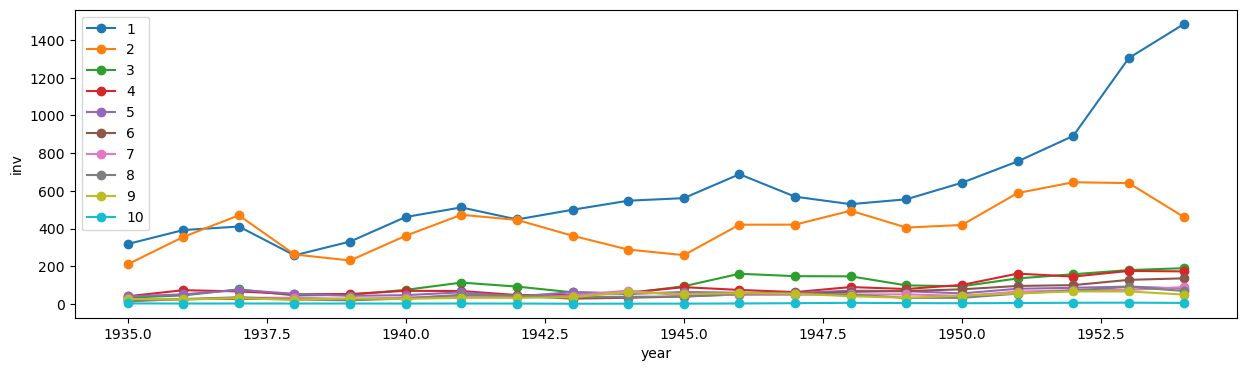

In [44]:
fig, ax = plt.subplots(figsize=(15,4))
for firm, chunk in df.groupby('firm'):
    plt.plot(chunk.year, chunk.inv, linestyle='-',marker='o',label = firm)
plt.legend()
plt.xlabel('year')
plt.ylabel('inv')
plt.show()

会社ごとや年ごとに`inv`の値がどのようにばらついているのかを確認します。

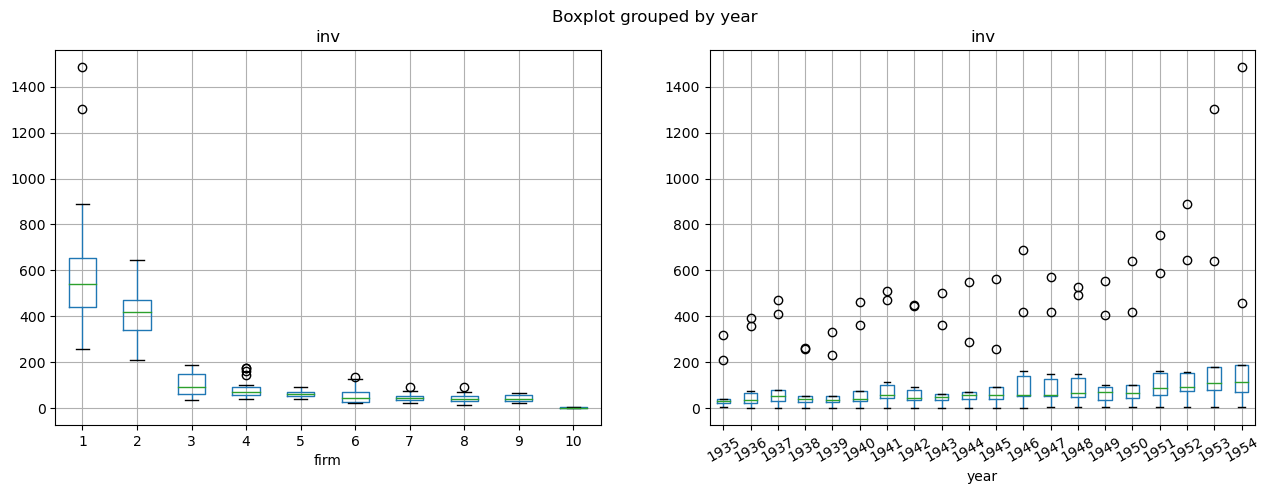

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
df.boxplot(by='firm',column='inv',ax=axs[0])
df.boxplot(by='year',column='inv',ax=axs[1], rot=30)
plt.show()

ここからパネルデータ分析を行います。
固定効果推定のために、各変数の値を会社の時間平均から引いた値を格納する変数を作ります。

In [64]:
features = ['inv', 'value', 'capital']
demean_features = ['demean_'+x for x in features]
df[demean_features] = df.groupby('firm', group_keys=False)[features].apply(lambda x: x - x.mean())

In [65]:
df.tail()

,firm,year,inv,value,capital,demean_inv,demean_value,demean_capital
195,10,1950,3.42,69.05,8.74,0.3355,-1.871,2.7985
196,10,1951,4.67,83.04,9.07,1.5855,12.119,3.1285
197,10,1952,6.00,74.42,9.93,2.9155,3.499,3.9885
198,10,1953,6.53,63.51,11.68,3.4455,-7.411,5.7385
199,10,1954,5.12,58.12,14.33,2.0355,-12.801,8.3885


まずは、Pooled OLSで推定してみます。

In [70]:
formula_pols = 'inv ~ value + capital'
result_pols = sm.OLS.from_formula(formula_pols, data=df).fit()
print(result_pols.summary())

                            OLS Regression Results                            
Dep. Variable:                    inv   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     426.6
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           2.58e-72
Time:                        02:01:31   Log-Likelihood:                -1191.8
No. Observations:                 200   AIC:                             2390.
Df Residuals:                     197   BIC:                             2399.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.7144      9.512     -4.491      0.0

続いて、固定効果モデルで推定します

In [77]:
formula_demean = 'demean_inv ~ demean_value + demean_capital'
result_demean = sm.OLS.from_formula(formula_demean, data=df).fit(cov_type='cluster', cov_kwds={'groups':df['firm']})
print(result_demean.summary())

                            OLS Regression Results                            
Dep. Variable:             demean_inv   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     28.31
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           0.000131
Time:                        02:16:20   Log-Likelihood:                -1070.8
No. Observations:                 200   AIC:                             2148.
Df Residuals:                     197   BIC:                             2157.
Df Model:                           2                                         
Covariance Type:              cluster                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -9.77e-15   2.05e-14     -0.